<a href="https://colab.research.google.com/github/atikhasan007/Machine-Learning/blob/main/Welcome_To_Colabfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:


import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'levir-cd' dataset.
Path to dataset files: /kaggle/input/levir-cd


In [27]:
# =========================================
# Imports
# =========================================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve


In [28]:
# =========================================
# Dataset
# =========================================
class LEVIRCDDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir_b = os.path.join(images_dir, 'B')
        self.images_dir_a = os.path.join(images_dir, 'A')
        self.masks_dir = os.path.join(images_dir, 'label')
        self.transform = transform
        self.images_b = sorted([f for f in os.listdir(self.images_dir_b) if f.endswith(('.png','.jpg','.jpeg'))])
        self.images_a = sorted([f for f in os.listdir(self.images_dir_a) if f.endswith(('.png','.jpg','.jpeg'))])
        self.masks = sorted([f for f in os.listdir(self.masks_dir) if f.endswith(('.png','.jpg','.jpeg'))])

    def __len__(self):
        return len(self.images_b)

    def __getitem__(self, idx):
        img_b = cv2.cvtColor(cv2.imread(os.path.join(self.images_dir_b, self.images_b[idx])), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        img_a = cv2.cvtColor(cv2.imread(os.path.join(self.images_dir_a, self.images_a[idx])), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
        if self.transform:
            augmented = self.transform(image=img_b, image1=img_a, mask=mask)
            img_b, img_a, mask = augmented['image'], augmented['image1'], augmented['mask']
        mask = mask.unsqueeze(0) if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).float().unsqueeze(0)
        return img_b, img_a, mask


In [29]:
# =========================================
# Transformations
# =========================================
train_transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
], additional_targets={'image1':'image'})

val_transform = A.Compose([
    A.Resize(256,256),
    ToTensorV2()
], additional_targets={'image1':'image'})


In [30]:
# =========================================
# Dataloaders
# =========================================
data_root = "/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD"
train_dataset = LEVIRCDDataset(os.path.join(data_root,'train'), transform=train_transform)
val_dataset = LEVIRCDDataset(os.path.join(data_root,'val'), transform=val_transform)
test_dataset = LEVIRCDDataset(os.path.join(data_root,'test'), transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [31]:
# =========================================
# Model Blocks
# =========================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = ConvBlock(in_ch, out_ch)
        self.conv2 = ConvBlock(out_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        return x2, self.pool(x2)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv1 = ConvBlock(out_ch+skip_ch, out_ch)
        self.conv2 = ConvBlock(out_ch, out_ch)
    def forward(self,x,skip):
        x = self.upconv(x)
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x,skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


In [32]:
# =========================================
# Hybrid Siamese U-Net
# =========================================
class HybridSiameseUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.encoder1a = EncoderBlock(in_ch,64)
        self.encoder2a = EncoderBlock(64,128)
        self.encoder3a = EncoderBlock(128,256)
        self.encoder4a = EncoderBlock(256,512)
        self.encoder1b = EncoderBlock(in_ch,64)
        self.encoder2b = EncoderBlock(64,128)
        self.encoder3b = EncoderBlock(128,256)
        self.encoder4b = EncoderBlock(256,512)
        self.bottleneck = ConvBlock(1024,1024)
        self.decoder4 = DecoderBlock(1024,1024,512)
        self.decoder3 = DecoderBlock(512,512,256)
        self.decoder2 = DecoderBlock(256,256,128)
        self.decoder1 = DecoderBlock(128,128,64)
        self.hybrid_conv1 = ConvBlock(64,32)
        self.hybrid_conv2 = ConvBlock(32,16)
        self.final_conv = nn.Conv2d(16,out_ch,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x1,x2):
        e1a,p1a = self.encoder1a(x1)
        e2a,p2a = self.encoder2a(p1a)
        e3a,p3a = self.encoder3a(p2a)
        e4a,p4a = self.encoder4a(p3a)
        e1b,p1b = self.encoder1b(x2)
        e2b,p2b = self.encoder2b(p1b)
        e3b,p3b = self.encoder3b(p2b)
        e4b,p4b = self.encoder4b(p3b)
        concat_e4 = torch.cat([e4a,e4b],dim=1)
        concat_e3 = torch.cat([e3a,e3b],dim=1)
        concat_e2 = torch.cat([e2a,e2b],dim=1)
        concat_e1 = torch.cat([e1a,e1b],dim=1)
        b = self.bottleneck(torch.cat([p4a,p4b],dim=1))
        d4 = self.decoder4(b,concat_e4)
        d3 = self.decoder3(d4,concat_e3)
        d2 = self.decoder2(d3,concat_e2)
        d1 = self.decoder1(d2,concat_e1)
        h = self.hybrid_conv1(d1)
        h = self.hybrid_conv2(h)
        return self.sigmoid(self.final_conv(h))


In [33]:
# =========================================
# Metrics
# =========================================
def calculate_metrics(outputs, labels, threshold=0.5):
    preds = (outputs>threshold).float()
    labels = labels.float()
    tp = torch.sum(preds*labels)
    tn = torch.sum((1-preds)*(1-labels))
    fp = torch.sum(preds*(1-labels))
    fn = torch.sum((1-preds)*labels)
    precision = tp/(tp+fp+1e-6)
    recall = tp/(tp+fn+1e-6)
    dice = 2*tp/(2*tp+fp+fn+1e-6)
    iou = tp/(tp+fp+fn+1e-6)
    acc = (tp+tn)/(tp+tn+fp+fn+1e-6)
    return acc.item(), precision.item(), recall.item(), dice.item(), iou.item(), preds


In [34]:
# =========================================
# Training Loop
# =========================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda'):
    model.to(device)
    history = {'train_loss':[], 'val_loss':[], 'train_iou':[], 'val_iou':[]}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        train_iou_sum = 0
        for x1,x2,y in train_loader:
            x1,x2,y = x1.to(device),x2.to(device),y.to(device)
            optimizer.zero_grad()
            out = model(x1,x2)
            loss = criterion(out,y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*x1.size(0)
            _,_,_,_,iou,_ = calculate_metrics(out,y)
            train_iou_sum += iou*x1.size(0)
        train_loss = running_loss/len(train_loader.dataset)
        train_iou = train_iou_sum/len(train_loader.dataset)
        # Validation
        model.eval()
        val_loss_sum = val_iou_sum = 0
        with torch.no_grad():
            for x1,x2,y in val_loader:
                x1,x2,y = x1.to(device),x2.to(device),y.to(device)
                out = model(x1,x2)
                loss = criterion(out,y)
                val_loss_sum += loss.item()*x1.size(0)
                _,_,_,_,iou,_ = calculate_metrics(out,y)
                val_iou_sum += iou*x1.size(0)
        val_loss = val_loss_sum/len(val_loader.dataset)
        val_iou = val_iou_sum/len(val_loader.dataset)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}')
    return model, history


In [35]:

# =========================================
# Grad-CAM
# =========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    def __call__(self, x1, x2):
        self.model.zero_grad()
        output = self.model(x1,x2)
        output[:,0,:,:].backward(torch.ones_like(output[:,0,:,:]))
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights*self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x1.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam

In [48]:
# =========================================
# Train Example
# =========================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HybridSiameseUNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device)


Epoch 1/100 | Train Loss: 0.6305, Val Loss: 0.5679 | Train IoU: 0.1139, Val IoU: 0.0025
Epoch 2/100 | Train Loss: 0.5290, Val Loss: 0.5052 | Train IoU: 0.2247, Val IoU: 0.2221
Epoch 3/100 | Train Loss: 0.5098, Val Loss: 0.4686 | Train IoU: 0.2975, Val IoU: 0.3335
Epoch 4/100 | Train Loss: 0.4890, Val Loss: 0.4737 | Train IoU: 0.3503, Val IoU: 0.3468
Epoch 5/100 | Train Loss: 0.4742, Val Loss: 0.4854 | Train IoU: 0.4025, Val IoU: 0.2997
Epoch 6/100 | Train Loss: 0.4678, Val Loss: 0.9388 | Train IoU: 0.4097, Val IoU: 0.3066
Epoch 7/100 | Train Loss: 0.4616, Val Loss: 0.4756 | Train IoU: 0.4337, Val IoU: 0.4285
Epoch 8/100 | Train Loss: 0.4503, Val Loss: 0.4315 | Train IoU: 0.4493, Val IoU: 0.4870
Epoch 9/100 | Train Loss: 0.4413, Val Loss: 0.4819 | Train IoU: 0.4723, Val IoU: 0.4162
Epoch 10/100 | Train Loss: 0.4343, Val Loss: 0.4214 | Train IoU: 0.4838, Val IoU: 0.5123
Epoch 11/100 | Train Loss: 0.4206, Val Loss: 0.4081 | Train IoU: 0.5106, Val IoU: 0.5390
Epoch 12/100 | Train Loss: 0.4

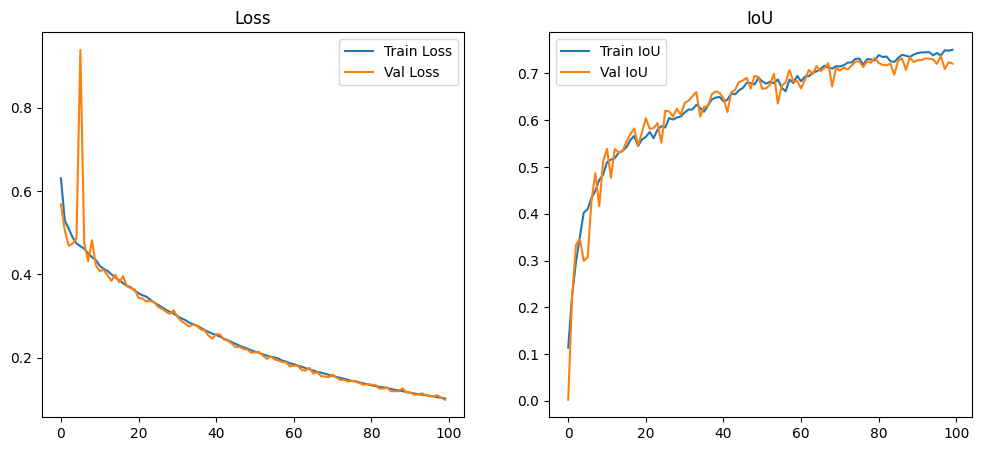

In [49]:

# =========================================
# Loss & IoU Curves
# =========================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.legend(); plt.title("IoU")
plt.show()


In [50]:
# =========================================
# Test Metrics: Confusion Matrix, Classification Report, ROC & PR Curves
# =========================================
all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for x1,x2,y in test_loader:
        x1,x2,y = x1.to(device), x2.to(device), y.to(device)
        out = model(x1,x2)
        all_probs.append(out.cpu().numpy().flatten())
        preds = (out>0.5).float()
        all_preds.append(preds.cpu().numpy().flatten())
        all_labels.append(y.cpu().numpy().flatten())

all_labels = np.concatenate(all_labels).astype(int) # Convert to integer type
all_preds = np.concatenate(all_preds).astype(int)   # Convert to integer type
all_probs = np.concatenate(all_probs)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", cr)

Confusion Matrix:
 [[7900468   60909]
 [  74760  352471]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9906    0.9923    0.9915   7961377
           1     0.8527    0.8250    0.8386    427231

    accuracy                         0.9838   8388608
   macro avg     0.9216    0.9087    0.9150   8388608
weighted avg     0.9836    0.9838    0.9837   8388608



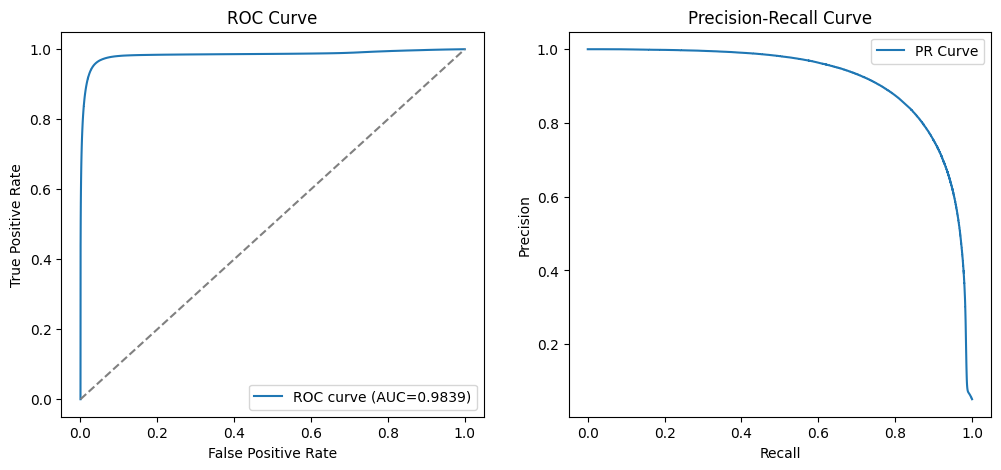

In [51]:

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.subplot(1,2,2)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


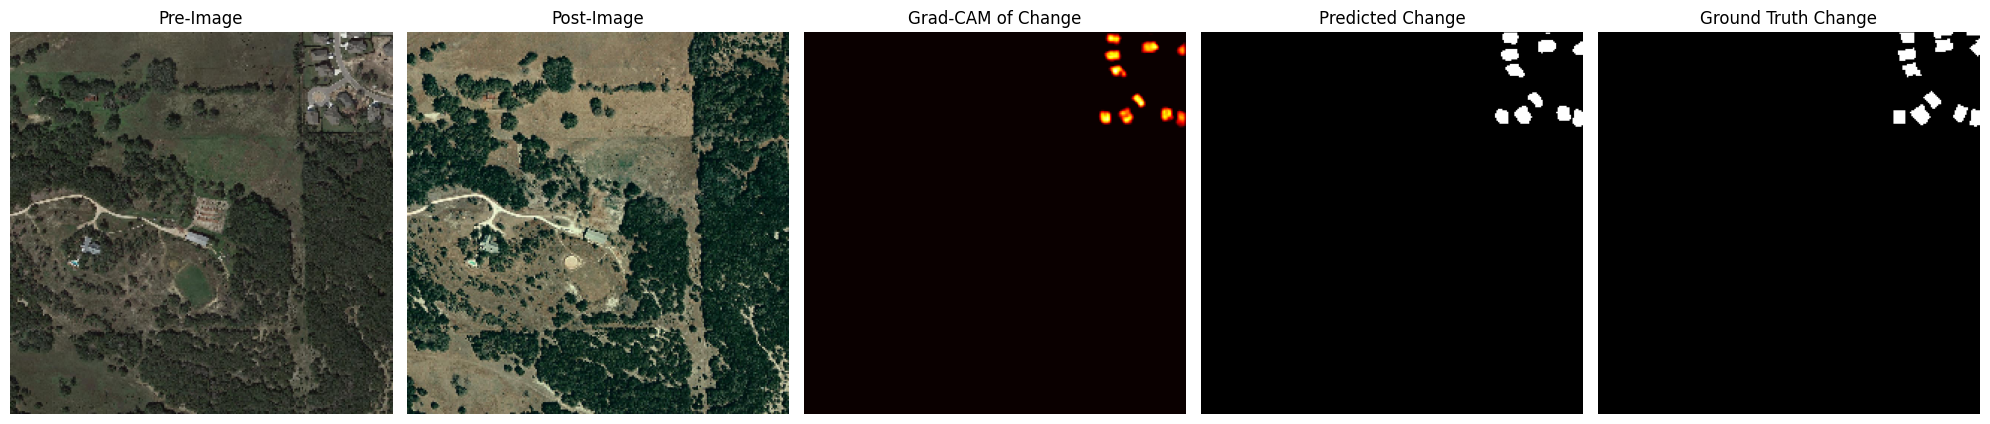

In [52]:
# =========================================
# Grad-CAM Visualization Example
# =========================================
x1, x2, y = next(iter(test_loader))

# Ensure x1, x2, and y are on the correct device
x1, x2, y = x1.to(device), x2.to(device), y.to(device)

# Initialize GradCAM
grad_cam = GradCAM(model, target_layer=model.hybrid_conv2)
cam_map = grad_cam(x1, x2)

# Get model prediction for comparison
with torch.no_grad():
    output = model(x1, x2)
    preds = (output > 0.5).float()

# Convert images, CAM map, ground truth, and prediction to numpy for plotting
img1_np = x1[0].cpu().permute(1,2,0).numpy()
img2_np = x2[0].cpu().permute(1,2,0).numpy()
cam_np = cam_map[0,0].cpu().numpy()
y_np = y[0,0].cpu().numpy() # Ground truth mask
preds_np = preds[0,0].cpu().numpy() # Predicted mask

plt.figure(figsize=(20, 8))

# Plot Pre-Image
plt.subplot(1, 5, 1)
plt.imshow(img1_np)
plt.title("Pre-Image")
plt.axis('off')

# Plot Post-Image
plt.subplot(1, 5, 2)
plt.imshow(img2_np)
plt.title("Post-Image")
plt.axis('off')

# Plot Grad-CAM of Change
plt.subplot(1, 5, 3)
plt.imshow(cam_np, cmap='hot') # Using 'hot' cmap for CAM itself
plt.title("Grad-CAM of Change")
plt.axis('off')

# Plot Predicted Change Mask
plt.subplot(1, 5, 4)
plt.imshow(preds_np, cmap='gray') # Binary prediction mask
plt.title("Predicted Change")
plt.axis('off')

# Plot Ground Truth Change Mask
plt.subplot(1, 5, 5)
plt.imshow(y_np, cmap='gray') # Ground truth mask
plt.title("Ground Truth Change")
plt.axis('off')

plt.tight_layout()
plt.show()


Visualizing Grad-CAM for Test Sample 1:


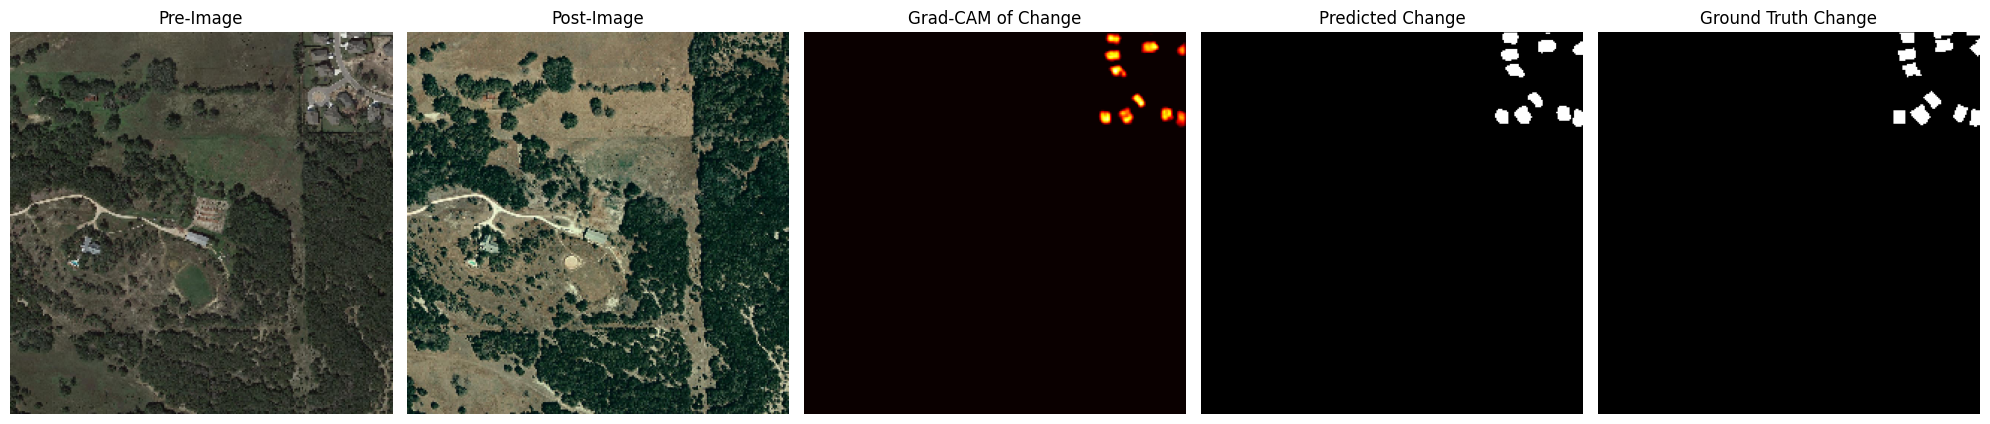


Visualizing Grad-CAM for Test Sample 2:


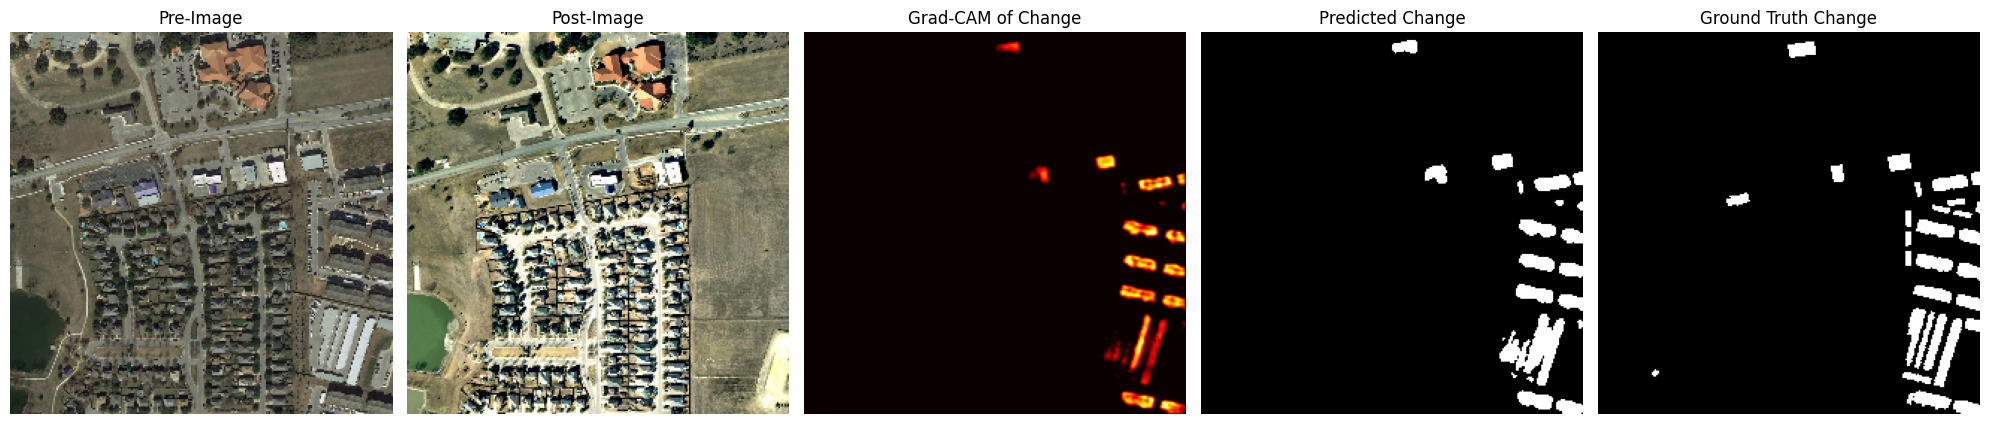


Visualizing Grad-CAM for Test Sample 3:


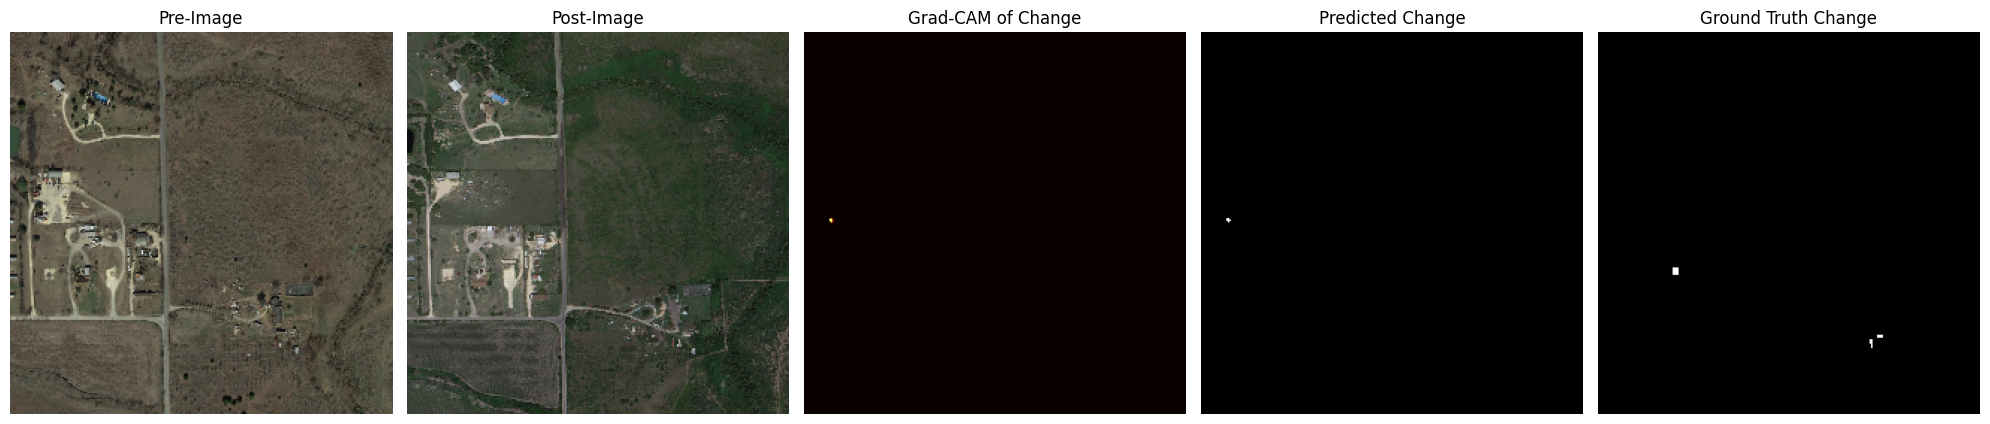

In [53]:
# =========================================
# Explainable AI: Grad-CAM Visualization Function
# =========================================

def visualize_gradcam(model, image_a, image_b, ground_truth_mask, target_layer, device):
    model.eval()
    # Ensure inputs are on the correct device
    img_a = image_a.unsqueeze(0).to(device) # Add batch dimension
    img_b = image_b.unsqueeze(0).to(device) # Add batch dimension
    # ground_truth_mask is (batch_size, 1, H, W) from test_loader
    # We need to take the first item of the batch and squeeze the channel dimension
    gt_mask_np = ground_truth_mask[0].cpu().numpy().squeeze(0) # For plotting: (H, W)

    # Initialize GradCAM
    grad_cam_instance = GradCAM(model, target_layer=target_layer)
    cam_map = grad_cam_instance(img_a, img_b)

    # Get model prediction for comparison
    with torch.no_grad():
        output = model(img_a, img_b)
        preds = (output > 0.5).float()

    # Convert tensors to numpy for plotting
    img1_np = img_a[0].cpu().permute(1,2,0).numpy()
    img2_np = img_b[0].cpu().permute(1,2,0).numpy()
    cam_np = cam_map[0,0].cpu().numpy()
    preds_np = preds[0,0].cpu().numpy()

    plt.figure(figsize=(20, 8))

    plt.subplot(1, 5, 1)
    plt.imshow(img1_np)
    plt.title("Pre-Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(img2_np)
    plt.title("Post-Image")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(cam_np, cmap='hot')
    plt.title("Grad-CAM of Change")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(preds_np, cmap='gray')
    plt.title("Predicted Change")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(gt_mask_np, cmap='gray') # Plot the correctly shaped ground truth mask
    plt.title("Ground Truth Change")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# =========================================
# Demonstrate Grad-CAM for a few test samples
# =========================================

# Get a few samples from the test loader
num_samples_to_visualize = 3
samples_iter = iter(test_loader)

for i in range(num_samples_to_visualize):
    try:
        x1_sample, x2_sample, y_sample = next(samples_iter)
        print(f"\nVisualizing Grad-CAM for Test Sample {i+1}:")
        visualize_gradcam(
            model=trained_model, # Use the trained model
            image_a=x1_sample[0], # Pass single image (remove batch dim)
            image_b=x2_sample[0], # Pass single image (remove batch dim)
            ground_truth_mask=y_sample,
            target_layer=trained_model.hybrid_conv2, # Use model's internal layer
            device=device
        )
    except StopIteration:
        print("No more samples in the test loader.")
        break

In [47]:
# =========================================
# Save Model
# =========================================
import h5py

# Save PyTorch state_dict in native PyTorch format (.pt)
torch.save(trained_model.state_dict(), 'trained_hybrid_siamese_unet.pt')
print("Trained model saved as 'trained_hybrid_siamese_unet.pt'")

# Save model weights to HDF5 format (.h5)
with h5py.File('trained_hybrid_siamese_unet_weights.h5', 'w') as f:
    for k, v in trained_model.state_dict().items():
        f.create_dataset(k, data=v.cpu().numpy())
print("Trained model weights saved as 'trained_hybrid_siamese_unet_weights.h5'")

Trained model saved as 'trained_hybrid_siamese_unet.pt'
Trained model weights saved as 'trained_hybrid_siamese_unet_weights.h5'
